## Recommandation system environment setting

This is a virtual [FNAC](https://en.wikipedia.org/wiki/Fnac) recommandation system environment for simulating its users preferences and orders.

<img src="imgs/Fnac_Logo.png" width="200">


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import copy

%matplotlib inline

In [2]:
category_dict = {}
category_dict["Informatique"] = ["Tablette", "Ordinateur", "Portable"]
category_dict["Film"] = ["DVD", "TV", "Cinéma"]

In [3]:
def generate_random_category(n, m):
    category_dict = {}
    for i in range(n):
        category_dict[i] = [str(i) + "-" + str(x) for x in list(range(m))]
    return category_dict
category_dict = generate_random_category(10, 20)

In [4]:
def count(dictionary):
    return sum(len(dictionary[x]) for x in dictionary.keys())

count(category_dict)

200

In [5]:
category_dict

{0: ['0-0',
  '0-1',
  '0-2',
  '0-3',
  '0-4',
  '0-5',
  '0-6',
  '0-7',
  '0-8',
  '0-9',
  '0-10',
  '0-11',
  '0-12',
  '0-13',
  '0-14',
  '0-15',
  '0-16',
  '0-17',
  '0-18',
  '0-19'],
 1: ['1-0',
  '1-1',
  '1-2',
  '1-3',
  '1-4',
  '1-5',
  '1-6',
  '1-7',
  '1-8',
  '1-9',
  '1-10',
  '1-11',
  '1-12',
  '1-13',
  '1-14',
  '1-15',
  '1-16',
  '1-17',
  '1-18',
  '1-19'],
 2: ['2-0',
  '2-1',
  '2-2',
  '2-3',
  '2-4',
  '2-5',
  '2-6',
  '2-7',
  '2-8',
  '2-9',
  '2-10',
  '2-11',
  '2-12',
  '2-13',
  '2-14',
  '2-15',
  '2-16',
  '2-17',
  '2-18',
  '2-19'],
 3: ['3-0',
  '3-1',
  '3-2',
  '3-3',
  '3-4',
  '3-5',
  '3-6',
  '3-7',
  '3-8',
  '3-9',
  '3-10',
  '3-11',
  '3-12',
  '3-13',
  '3-14',
  '3-15',
  '3-16',
  '3-17',
  '3-18',
  '3-19'],
 4: ['4-0',
  '4-1',
  '4-2',
  '4-3',
  '4-4',
  '4-5',
  '4-6',
  '4-7',
  '4-8',
  '4-9',
  '4-10',
  '4-11',
  '4-12',
  '4-13',
  '4-14',
  '4-15',
  '4-16',
  '4-17',
  '4-18',
  '4-19'],
 5: ['5-0',
  '5-1',
  '5-2',


In [54]:
class Clients:
    def __init__(self, n_client, category_dict, desire_threshold=3):
        self.category_dict = category_dict
        self.category_list = list(category_dict.keys())
        self.n_client = n_client
        self.n_category = len(category_dict.keys())
        self.n_commodity = count(category_dict)
        
        self.buy_threshold_list = [desire_threshold] * n_client
        self.cart_threshold_list = [desire_threshold*0.8] * n_client
        self.click_threshold_list = [desire_threshold*0.6] * n_client
        
        
        self.preference_matrix = np.zeros((n_client, self.n_commodity))
        self.desire_matrix = copy.copy(self.preference_matrix)
        
        self.reward_history = []
        self.regret_history = []
        self.reward_sum_each_step = []
        
        self.generate_client_distribution()
        
    def generate_client_distribution(self):
        proba_category = np.random.uniform(0, 0.9, (self.n_client, self.n_category))
        proba_commodity_list = []
        for j in range(proba_category.shape[1]):
            #print('---aaa---', np.expand_dims(proba_category[:,j],1).shape)
            proba_commodity_list.append(np.repeat(np.expand_dims(proba_category[:,j],1), len(self.category_dict[self.category_list[j]]), axis=1))
        self.preference_matrix = np.hstack(proba_commodity_list)
        #print(proba_commodity_list[0].shape)
        #print(proba_commodity_list[1].shape)
        #print(self.proba_commodity.shape)
        self.preference_matrix += np.random.uniform(0, 0.1, (self.n_client, self.n_commodity))
        return
    
    def get_clients(self, n):
        return np.random.choice(list(range(self.n_client)), n, replace=False)
    
    def update_desire(self, client, rate_rise=None):
#         if rate_decay is not None:
#             self.desire_matrix *= 1 - rate_decay
        
        # if a commodity's desire has been over the thresholf for a long time but not buy things at our site,
        # the client may probably buy it somewhere else, so its desire will decrease to 0
        for i in range(len(self.desire_matrix[client])):
            if self.desire_matrix[client][i] > 3*self.buy_threshold_list[client]:
                self.desire_matrix[client][i] = 0  
        
        if rate_rise is None:
            rate_rise = np.mean(self.desire_threshold_list) * 0.5
        if rate_rise < 0:
            rate_rise = 0
        self.desire_matrix[client] += rate_rise * self.preference_matrix[client]
    
    def get_waiting_list(self, client):
        client_desire = self.desire_matrix[client]
        buy = np.array(np.where(client_desire>self.buy_threshold_list[client])[0])
        cart = np.array(np.where(client_desire>self.cart_threshold_list[client])[0])
        click = np.array(np.where(client_desire>self.click_threshold_list[client])[0])
        print('click', click)
        
        for i in range(len(click)):
            if click[i] in cart:
                click[i] = 0
        
        for i in range(len(cart)):
            if cart[i] in buy:
                cart[i] = 0
        
        waiting_list = [buy, cart, click]
        
        return waiting_list
    
    def return_command(self, client, recommandation_list):
        client_waiting_list = self.get_waiting_list(client)[0]
        command_list = np.array([x for x in recommandation_list if x in client_waiting_list])
                
        
        print('client_waiting_list',client_waiting_list)
        print('command_list',command_list)
        return command_list
    
    def return_cart(self, client, recommandation_list):
        client_waiting_list = self.get_waiting_list(client)[1]
        cart_list = np.array([x for x in recommandation_list if x in client_waiting_list])
                
        
        print('client_waiting_list', client_waiting_list)
        print('cart_list', cart_list)
        return cart_list
    
    def return_click(self, client, recommandation_list):
        client_waiting_list = self.get_waiting_list(client)[0]
        click_list = np.array([x for x in recommandation_list if x in client_waiting_list])
                
        
        print('client_waiting_list',client_waiting_list)
        print('click_list',click_list)
        return click_list
    
#     def get_reward(self, client, recommandation_list):
#         articles_bought = self.return_command(client, recommandation_list)
#         self.reward_history.append(len(articles_bought))
#         return len(articles_bought)
    
    def do_purchase(self, client, command_list):
        for c in command_list:
            self.desire_matrix[client][c] = 0


    def get_reward(self, client, recommandation_list, articles_bought, articles_cart, articles_click):
        print('recommandation_list', recommandation_list)
        #articles_bought = self.return_command(client, recommandation_list)
        reward_list = [0]*len(recommandation_list)
        for a in articles_bought:
            index = np.where(recommandation_list==a)[0][0]
            #print('---aaa---', index)
            reward_list[index] += 1
            
        for a in articles_cart:
            index = np.where(recommandation_list==a)[0][0]
            #print('---aaa---', index)
            reward_list[index] += 0.7
            
        for a in articles_click:
            index = np.where(recommandation_list==a)[0][0]
            #print('---aaa---', index)
            reward_list[index] += 0.2
            
        #self.reward_history.append(reward_list) 
        #self.reward_sum_each_step.append(sum(reward_list))
        print('reward_list', reward_list)
        return reward_list
        
    def get_regret(self, client, recommandation_list, reward_list):
        #articles_bought = self.return_command(client, recommandation)
        articles_wanted_to_buy = self.get_waiting_list(client)[0]
        #regret = min(len(articles_wanted_to_buy), len(recommandation_list)) - sum(self.get_reward(client, recommandation_list))
        regret = min(len(articles_wanted_to_buy), len(recommandation_list)) - sum(reward_list)
        #self.regret_history.append(regret)
        return regret
    
    def update_history(self, reward_list, regret):
        self.reward_history.append(reward_list) 
        self.reward_sum_each_step.append(sum(reward_list))
        self.regret_history.append(regret)

In [19]:
np.where(np.array([1,2,3,4,3])==3)[0][0]

2

In [22]:
class AgentBase():
    def __init__(self, commodity_number, recommendation_length):
        raise NotImplementedError()
    
    def recommend(self, online_client):
        raise NotImplementedError()
    
    def update_state(self, recommendation_chosen, reward):
        raise NotImplementedError()
        
    def get_agent_name(self):
        return self.name

In [23]:
class RandomAgent(AgentBase):
    def __init__(self, user_number, commodity_number, recommendation_length=5):
        self.name = 'random agent'
        self.user_number = user_number
        self.commodity_number = commodity_number
        self.recommendation_length = recommendation_length
        self.recommendation_history = []
        self.reward_history = []
        self.reward_sum_each_step = []
        self.t = 1
        
        self.purchase_history = []
        for i in range(self.user_number):
            self.purchase_history.append([])
        
    def recommend(self, client_id):
        return np.random.choice(range(self.commodity_number), self.recommendation_length, replace=False)
    
    def update_state(self, client_id, recommendations_chosen, reward_list, articles_bought):
        
        self.t += 1
        self.purchase_history[client_id].append(articles_bought)
        
        self.recommendation_history.append(recommendations_chosen)
        self.reward_history.append(reward_list)
        self.reward_sum_each_step.append(sum(reward_list))

In [24]:
class UCBAgent(AgentBase):
    def __init__(self, user_number, commodity_number, recommendation_length=5, constant=1):
        self.name = 'ucb agent'
        self.commodity_number = commodity_number
        self.user_number = user_number
        self.recommendation_length = recommendation_length
        self.recommendation_history = []
        self.reward_history = []
        self.reward_sum_each_step = []
        
        self.purchase_history = []
        for i in range(self.user_number):
            self.purchase_history.append([])
        
        self.n_by_commodity = np.zeros((user_number, commodity_number))  # How many times that a commodity has been recomended to a user
        self.reward_by_commodity = np.zeros((user_number, commodity_number))  # How much reward has been given to a specific user by a specific commodity
        self.constant = constant
        self.t = 1
        
    def recommend(self, client_id):
        ucbs = [self.reward_by_commodity[client_id, a] / self.n_by_commodity[client_id, a] 
                + self.constant*np.sqrt(np.log(self.t)/self.n_by_commodity[client_id, a]) 
                for a in range(self.commodity_number)]
        ucbs = np.array(ucbs)
        return ucbs.argsort()[-self.recommendation_length:][::-1] # select the top self.recommendation_length articles, return their indices by order
        
    def update_state(self, client_id, recommendations_chosen, reward_list, articles_bought):
        for i, a in enumerate(recommendations_chosen):
            self.n_by_commodity[client_id, a] += 1
            self.reward_by_commodity[client_id, a] += reward_list[i]
        
        self.t += 1
        self.purchase_history[client_id].append(articles_bought)
        
        self.recommendation_history.append(recommendations_chosen)
        self.reward_history.append(reward_list)
        self.reward_sum_each_step.append(sum(reward_list))

In [25]:
class UCBAgent_Adapted(AgentBase):
    def __init__(self, user_number, commodity_number, recommendation_length=5, constant=1):
        self.name = 'ucb agent'
        self.commodity_number = commodity_number
        self.user_number = user_number
        self.recommendation_length = recommendation_length
        self.recommendation_history = []
        self.reward_history = []
        self.reward_sum_each_step = []
        
        self.purchase_history = []
        for i in range(self.user_number):
            self.purchase_history.append([])
        
        self.n_by_commodity = np.zeros((user_number, commodity_number))  # How many times that a commodity has been recomended to a user
        self.reward_by_commodity = np.zeros((user_number, commodity_number))  # How much reward has been given to a specific user by a specific commodity
        self.constant = constant
        self.t = 1
        
    def recommend(self, client_id):
        ucbs = [self.reward_by_commodity[client_id, a] / self.n_by_commodity[client_id, a] 
                + self.constant*np.sqrt(np.log(self.t)/self.n_by_commodity[client_id, a]) 
                for a in range(self.commodity_number)]
        ucbs = np.array(ucbs)
        
        recommend_order = ucbs.argsort()[::-1]
        recently_purchased_commodities = set()
        for i in [-1,-2,-3]: 
            if len(self.purchase_history[client_id]) >= -i:
                recently_purchased_commodities.update(self.purchase_history[client_id][i])
        
        recommendation_list = []
        for i in range(len(recommend_order)):
            if recommend_order[i] not in recently_purchased_commodities:
                recommendation_list.append(recommend_order[i])
            if len(recommendation_list) == self.recommendation_length:
                break
        
        return recommendation_list
        
    def update_state(self, client_id, recommendations_chosen, reward_list, articles_bought):
        for i, a in enumerate(recommendations_chosen):
            self.n_by_commodity[client_id, a] += 1
            self.reward_by_commodity[client_id, a] += reward_list[i]
        
        self.t += 1
        self.purchase_history[client_id].append(articles_bought)
        
        self.recommendation_history.append(recommendations_chosen)
        self.reward_history.append(reward_list)
        self.reward_sum_each_step.append(sum(reward_list))
        

In [41]:
def run(env, agent, n):
    for i in range(n):
        print('round', i)
        active_clients = env.get_clients(1)
        
        for c in active_clients:
            env.update_desire(c, rate_rise=0.5)
            recomedation_list = agent.recommend(c)
            articles_buy = env.return_command(c, recomedation_list)
            articles_cart = env.return_cart(c, recomedation_list)
            articles_click = env.return_click(c, recomedation_list)
            
            reward_list = env.get_reward(c, recomedation_list, articles_buy, articles_cart, articles_click)
            regret = env.get_regret(c, recomedation_list, reward_list)
            print('regret', regret, '\treward', sum(reward_list))
            env.do_purchase(c, articles_buy)
            env.update_history(reward_list, regret)
            agent.update_state(c, recomedation_list, reward_list, articles_buy)

In [55]:
C = Clients(n_client=1, category_dict=category_dict)
print(C.n_commodity)


            

200


In [56]:
C1 = copy.deepcopy(C)
random_agent = RandomAgent(C1.n_client, C1.n_commodity, recommendation_length=2)
run(C1, random_agent, 100)

round 0
click []
client_waiting_list []
command_list []
click []
client_waiting_list []
cart_list []
click []
client_waiting_list []
click_list []
recommandation_list [ 29 190]
reward_list [0, 0]
click []
regret 0 	reward 0
round 1
click []
client_waiting_list []
command_list []
click []
client_waiting_list []
cart_list []
click []
client_waiting_list []
click_list []
recommandation_list [ 44 125]
reward_list [0, 0]
click []
regret 0 	reward 0
round 2
click []
client_waiting_list []
command_list []
click []
client_waiting_list []
cart_list []
click []
client_waiting_list []
click_list []
recommandation_list [182 115]
reward_list [0, 0]
click []
regret 0 	reward 0
round 3
click []
client_waiting_list []
command_list []
click []
client_waiting_list []
cart_list []
click []
client_waiting_list []
click_list []
recommandation_list [116  57]
reward_list [0, 0]
click []
regret 0 	reward 0
round 4
click [ 49  59 120 124 129 131 133 134 138 139]
client_waiting_list []
command_list []
click [ 4

   0   0   0   0]
cart_list []
click [  0   1   2   3   4   5   6   7   8  10  11  13  14  15  16  17  18  19
  21  26  28  40  49  50  59  61  64  65  66  67  68  69  71  73  75  77
  78  82  83  91  97  99 120 124 129 131 133 134 136 138 139 143 151 153
 157 160 162 168 171 175 176 180 181 182 183 184 185 186 187 188 189 192
 193 194 195 196 197 198 199]
client_waiting_list [  0   1   2   3   4   5   6   7   8  10  11  13  14  15  16  17  18  19
  21  26  28  40  50  82  91  97  99 136 143 151 153 157 180 181 182 183
 184 185 186 187 188 189 192 193 194 195 196 197 198 199]
click_list [99]
recommandation_list [102  99]
reward_list [0, 1.2]
click [  0   1   2   3   4   5   6   7   8  10  11  13  14  15  16  17  18  19
  21  26  28  40  49  50  59  61  64  65  66  67  68  69  71  73  75  77
  78  82  83  91  97  99 120 124 129 131 133 134 136 138 139 143 151 153
 157 160 162 168 171 175 176 180 181 182 183 184 185 186 187 188 189 192
 193 194 195 196 197 198 199]
regret 0.8 	reward 1.2

client_waiting_list [  0   1   2   3   4   5   8  10  11  12  14  15  16  17  18  19  21  22
  24  25  26  29  31  35  36  37  38  39  42  43  44  45  46  47  50  51
  53  54  55  56  57  58  61  64  65  66  67  68  69  71  73  75  77  78
  80  81  84  85  86  87  89  90  91  92  93  94  95  96  97  98  99 121
 122 123 125 127 128 135 136 140 141 142 144 145 147 149 151 152 154 155
 156 157 159 160 162 168 171 175 176 177 180 182 184 185 186 195 196 199]
command_list [39]
click [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  24  25  26  29  31  35  36  37  38  39  40  42  43
  44  45  46  47  50  51  53  54  55  56  57  58  60  61  62  63  64  65
  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  84
  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 103
 104 115 118 120 121 122 123 125 127 128 129 131 133 134 135 136 140 141
 142 143 144 145 147 149 151 152 154 155 156 157 159 160 161 162 164 165
 166 1

client_waiting_list [  0   2   3   0   0   0   0   0   0  19   0   0   0   0   0   0   0  29
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0  62  63   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  91   0   0
   0   0   0  97   0  99   0 101 103   0 115 118   0   0   0   0   0   0
   0   0   0   0   0   0   0   0 136   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0 164   0   0   0
 170   0   0   0   0   0   0   0   0 186   0   0   0   0   0   0   0   0
   0 196   0   0]
cart_list []
click [  0   2   3   6   7   9  10  12  13  17  18  19  20  22  23  24  25  26
  27  28  29  30  31  32  33  34  35  36  37  38  40  41  42  43  44  45
  47  48  49  50  51  52  53  54  55  57  58  59  60  61  62  63  65  66
  67  69  70  72  73  74  75  76  78  79  80  81  82  83  84  86  87  88
  89  91  92  93  94  95  96  97  98  99 100 101 103 104 106 107 10

click [  0   1   2   3   4   5   7   8   9  10  11  13  14  15  16  17  20  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  38  39  40  41
  42  45  46  48  49  50  51  52  55  56  59  60  62  63  65  66  67  68
  70  71  72  73  74  75  76  78  79  82  83  84  85  86  87  90  91  93
  94  95  97  98  99 100 103 104 106 107 109 111 114 115 117 118 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 148 149 150 151 153 154 156 157 158 159 161
 162 163 164 165 166 167 168 170 171 172 174 176 177 178 179 180 181 182
 183 184 185 186 187 188 189 190 191 192 195 196 197 198 199]
client_waiting_list [  0   1   2   3   7   8   9  10  11  13  14  20  23  24  26  29  30  31
  32  33  34  35  38  39  40  41  46  49  50  52  55  56  59  60  62  63
  65  66  67  70  72  73  74  75  76  78  79  82  84  85  86  87  90  91
  93  94  97  98  99 100 103 104 115 118 120 121 123 124 126 130 131 132
 134 135 136 137 138 139 140 141 142

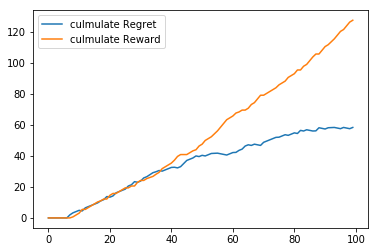

In [57]:
plt.plot(np.cumsum(C1.regret_history))
plt.plot(np.cumsum(C1.reward_sum_each_step))
plt.legend(["culmulate Regret", "culmulate Reward"])

In [58]:
len(C1.reward_sum_each_step)

100

In [59]:
C2 = copy.deepcopy(C)
ucb_agent = UCBAgent(C2.n_client, C2.n_commodity, recommendation_length=2)
run(C2, ucb_agent, 100)

round 0
click []
client_waiting_list []
command_list []
click []
client_waiting_list []
cart_list []
click []
client_waiting_list []
click_list []
recommandation_list [199  62]
reward_list [0, 0]
click []
regret 0 	reward 0
round 1
click []
client_waiting_list []
command_list []
click []
client_waiting_list []
cart_list []
click []
client_waiting_list []
click_list []
recommandation_list [99 74]
reward_list [0, 0]
click []
regret 0 	reward 0
round 2
click []
client_waiting_list []
command_list []
click []
client_waiting_list []
cart_list []
click []
client_waiting_list []
click_list []
recommandation_list [ 0 76]
reward_list [0, 0]
click []
regret 0 	reward 0
round 3
click []
client_waiting_list []
command_list []
click []
client_waiting_list []
cart_list []
click []
client_waiting_list []
click_list []
recommandation_list [102  53]
reward_list [0, 0]
click []
regret 0 	reward 0
round 4
click [ 49  59 120 124 129 131 133 134 138 139]
client_waiting_list []
command_list []
click [ 49  5

/home/dongwenjian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
/home/dongwenjian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars


 [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  25  26  27  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  65  69  75  80  81  83  84  85  86  87  88  89  90  91
  92  94  96  97  98  99 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 180 181 182 183 184 185 186 187
 188 189 190 191 192 193 194 195 196 197 198 199]
client_waiting_list [  0   1   2   3   4   5   6   7   8  10  11  12  13  14  15  16  18  19
  20  21  22  25  26  27  29  30  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  80  83  84  85  86  87  88  89  90  91  92  94  96  97  98  99 120
 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138
 139 140 141 142 143 144 145 146 147 148 149 150 151 

click [  0   1   2   4   5   6   7   8   9  10  11  12  13  14  15  16  18  19
  20  21  22  24  25  26  28  29  30  31  32  33  34  35  36  37  39  40
  41  42  43  45  46  47  48  49  50  51  52  53  54  55  56  58  59  60
  61  62  64  65  66  67  68  69  70  71  72  74  75  76  77  78  79  80
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 103 104 115 118 120 122 123 124 125 126 127 128 129 130 131 132 133
 134 135 137 138 139 140 141 142 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 164 165 166 168 169 170 171 173 174
 175 176 177 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193
 194 195 196 197 198 199]
client_waiting_list [  0   1   2   4   6   7   8   9  10  11  12  13  14  16  18  19  20  21
  22  24  25  26  28  29  30  31  32  34  35  37  39  40  41  42  43  45
  46  47  50  51  52  53  54  55  56  58  65  66  67  68  69  71  75  78
  80  82  83  84  85  87  88  89  90  91  92  93  94  95  96  97  98  99

click [  3   4   5  12  14  15  16  17  18  20  21  22  23  24  25  26  27  28
  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46
  47  48  49  50  52  53  54  55  56  57  58  59  60  61  62  63  64  65
  66  67  69  70  71  72  74  75  76  77  79  80  81  82  83  84  85  86
  87  88  89  92  93  94  95  96 101 103 104 106 109 114 115 117 118 120
 121 122 123 124 125 126 127 128 129 130 131 132 133 135 136 137 138 139
 140 141 142 143 144 145 147 149 150 151 152 154 155 156 157 159 160 161
 162 164 165 166 168 169 170 171 172 173 174 175 176 177 179 181 182 183
 187 188 189 192 193 194 195 197 198]
client_waiting_list [  3   4   5  12  15  16  17  22  23  24  25  26  27  28  29  30  31  32
  33  34  35  36  38  39  41  42  44  45  46  47  48  49  50  52  54  56
  57  59  60  61  64  65  66  67  69  70  71  72  74  75  77  81  82  83
  86  88  92  93  95  96 120 121 122 123 124 125 126 127 128 129 130 132
 133 135 136 137 138 139 140 143 144 147 150 157 160 161 162

click [  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  17  18  19
  21  22  23  25  27  30  31  33  35  36  37  38  39  40  41  43  44  45
  46  47  48  49  50  51  53  54  55  56  57  58  59  60  61  62  63  67
  69  70  71  72  73  74  75  76  77  78  79  81  82  83  84  85  86  87
  88  89  90  91  92  94  95  96  97  98  99 101 103 104 106 107 109 111
 114 115 117 118 120 121 124 127 128 129 131 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 148 149 151 152 153 154 155 156 158 159 160
 161 163 164 165 167 169 170 172 173 175 177 178 179 180 181 182 183 184
 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199]
client_waiting_list [  0   2   3   4   5   6  10  12  14  15  17  18  19  21  23  30  31  33
  35  36  37  40  43  45  46  48  49  50  51  53  54  55  56  59  60  61
  62  63  67  69  70  71  72  74  75  76  77  79  82  83  84  85  86  87
  88  89  90  91  92  94  96  97  98  99 103 104 115 118 120 121 127 128
 129 131 133 134 135 136 139 140 141

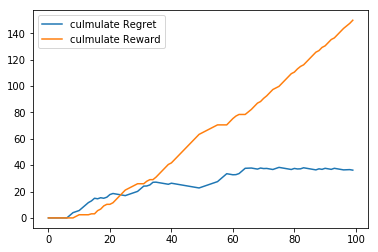

In [60]:
plt.plot(np.cumsum(C2.regret_history))
plt.plot(np.cumsum(C2.reward_sum_each_step))
plt.legend(["culmulate Regret", "culmulate Reward"])

In [61]:
C3 = copy.deepcopy(C)
ucb_adapted_agent = UCBAgent_Adapted(C3.n_client, C3.n_commodity, recommendation_length=2)
run(C3, ucb_adapted_agent, 100)

round 0
click []
client_waiting_list []
command_list []
click []
client_waiting_list []
cart_list []
click []
client_waiting_list []
click_list []
recommandation_list [199, 62]
reward_list [0, 0]
click []
regret 0 	reward 0
round 1
click []
client_waiting_list []
command_list []
click []
client_waiting_list []
cart_list []
click []
client_waiting_list []
click_list []
recommandation_list [99, 74]
reward_list [0, 0]
click []
regret 0 	reward 0
round 2
click []
client_waiting_list []
command_list []
click []
client_waiting_list []
cart_list []
click []
client_waiting_list []
click_list []
recommandation_list [0, 76]
reward_list [0, 0]
click []
regret 0 	reward 0
round 3
click []
client_waiting_list []
command_list []
click []
client_waiting_list []
cart_list []
click []
client_waiting_list []
click_list []
recommandation_list [102, 53]
reward_list [0, 0]
click []
regret 0 	reward 0
round 4
click [ 49  59 120 124 129 131 133 134 138 139]
client_waiting_list []
command_list []
click [ 49  

/home/dongwenjian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
/home/dongwenjian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars


click [  0   1   2   3   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  26  27  28  37  38  40  43  44  47  48  53  54  55  57  58
  65  66  67  68  69  71  73  75  78  80  81  82  83  84  85  86  87  89
  90  91  93  94  95  96  97  98  99 140 141 142 143 145 147 149 151 152
 153 154 155 156 159 160 162 168 171 175 180 181 182 183 184 185 186 187
 188 189 190 191 192 193 194 195 196 197 198 199]
client_waiting_list [  0   1   2   3   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  26  27  37  38  40  43  44  47  48  53  54  55  57  58  80  81
  83  84  85  86  87  89  90  91  93  94  95  96  97  98  99 140 141 142
 143 145 147 149 151 152 153 154 155 156 159 180 181 182 183 184 185 186
 187 188 189 190 191 192 193 194 195 196 197 198 199]
command_list [87]
click [  0   1   2   3   5   6   7   8   9  10  11  13  14  16  17  18  19  20
  21  23  24  26  27  28  37  38  40  43  44  47  48  53  54  55  57  58
  65  66  67  68  69  71  73  75  78  80  8

click [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  15  16  17  18
  19  20  21  22  23  25  27  29  30  31  32  33  34  35  36  37  38  39
  40  42  43  44  45  46  48  49  50  51  52  53  54  55  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  74  75  76  77  78
  79  80  82  83  84  85  86  87  88  89  90  91  92  94  96  97  98  99
 100 103 104 115 118 121 122 123 124 125 126 127 128 130 131 132 134 135
 136 139 140 141 142 144 145 146 148 149 150 151 152 153 154 155 156 157
 158 159 160 161 162 164 165 166 168 169 170 171 173 174 175 176 177 179
 180 181 182 183 184 185 186 188 189 190 191 192 193 194 195 196 198 199]
client_waiting_list [  0   1   2   4   6   7   8   9  10  11  12  13  15  16  18  19  20  21
  22  25  29  30  31  32  33  34  35  36  37  39  40  42  43  45  46  48
  49  50  51  52  53  54  55  56  58  59  64  65  66  67  68  69  71  75
  78  80  82  83  84  85  86  87  88  89  90  91  92  94  96  97  98  99
 122 123 124 125 126 127

click [  0   2   3   4   5   6   7  10  12  14  15  17  18  20  22  23  24  25
  26  27  28  29  31  32  34  35  37  38  39  40  41  42  43  44  45  46
  47  50  51  52  53  54  55  56  57  58  60  61  62  63  64  65  67  69
  70  71  72  74  75  76  77  79  80  81  82  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 101 103 104 106 107 109 111 114 115
 117 118 120 122 123 124 125 126 127 128 129 130 131 132 133 134 136 137
 138 140 141 142 143 144 145 146 147 148 149 150 151 153 154 155 156 157
 158 159 160 161 162 164 165 166 167 168 169 170 171 172 173 174 175 176
 177 178 179 181 183 185 186 187 188 189 190 191 192 193 194 195 196 197
 198]
client_waiting_list [  3   4   5  12  14  15  17  20  22  23  24  25  26  27  28  29  31  32
  34  35  37  38  39  40  41  42  43  44  45  46  47  50  52  53  54  55
  56  57  58  60  61  64  65  67  69  70  71  72  74  75  77  79  80  81
  82  84  85  86  87  88  89  92  93  94  95  96 104 120 122 123 124 125
 126 127 128 129 13

click [  0   1   2   3   4   5   6   8   9  10  11  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  32  33  34  36  38  39  41
  42  44  47  48  49  51  52  55  57  58  59  61  62  63  67  69  70  71
  72  73  74  75  76  77  78  80  81  83  84  86  87  90  93  95  97  98
  99 101 103 104 106 107 109 111 114 115 117 118 120 121 122 123 124 125
 126 129 130 132 133 134 135 136 137 138 139 141 142 143 145 146 147 148
 149 150 151 152 153 154 156 157 158 159 160 161 163 164 165 167 172 173
 175 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193
 194 195 196 197 199]
client_waiting_list [  0   1   2   3   4   5   6   8   9  10  11  13  14  15  17  18  19  20
  21  22  23  25  26  27  30  33  34  36  38  39  41  44  47  48  49  51
  55  57  58  59  61  62  63  67  69  70  71  72  74  75  76  77  81  83
  84  86  87  90  95  97  98  99 103 104 115 118 120 121 124 129 133 134
 135 136 137 138 139 141 142 143 145 146 148 149 151 152 153 154 156 158
 15

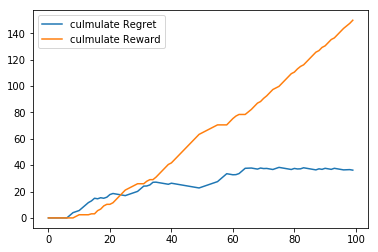

In [62]:
plt.plot(np.cumsum(C3.regret_history))
plt.plot(np.cumsum(C3.reward_sum_each_step))
plt.legend(["culmulate Regret", "culmulate Reward"])

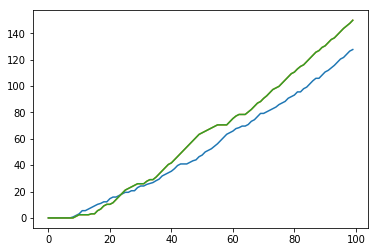

In [63]:
plt.plot(np.cumsum(C1.reward_sum_each_step), label='random')
plt.plot(np.cumsum(C2.reward_sum_each_step), label='ucb')
plt.plot(np.cumsum(C3.reward_sum_each_step), label='ucb_adapted')

In [193]:
np.random.choice([1,2,3], 2, replace=False)

array([2, 1])

In [137]:
C.update_desire(C.get_clients(1), rate_rise=0.5)

In [124]:
C.desire_matrix

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.42446944, 0.38809191, 0.40641486, 0.35376478, 0.34405558,
        0.33749734]])

In [95]:
C.get_waiting_list(0)

array([], dtype=float64)

In [85]:
np.array([[1], [1,2]])

array([list([1]), list([1, 2])], dtype=object)

In [15]:
a = np.array([1,2,3])
b = np.array([4,5,6])
np.vstack([a,b])

array([[1, 2, 3],
       [4, 5, 6]])

In [17]:
a = 5
3<a<6

True